## CNN inference example

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import pycomlink as pycml
from pycomlink.processing.pytorch_util import run_inference

c:\Users\lukas\Documents\OpenSense\pycomlink\pycomlink\io\examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# Load data

data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

__Load DL model and set up a path for model weights__

In [4]:
# TODO: So we need one simple function for example polz_2025_cnn, which loads specific cnn.py model and weights from url, so the none of those will be in pycomlink
# the user should only choose a model by a name and the rest of the complexity is hidden

## something like:?
#weights_url = ...
#model_url = ...
#result = pytorch_util.cnn_wd(model_url,weights_url, data=tl_normed)

weights_path = 'C:/Users/lukas/Documents/OpenSense/temp_for_cnn_models/dummy_model/model_epoch_15.pth'


In [5]:
# Dataarray shape is expected to be (time, channels, cml_id)
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

# TODO: standardization still needed ?

In [6]:
# cmls['cml_id'] = range(len(cmls['cml_id']))
# cmls['time'] = range(len(cmls['time']))

result = run_inference.cnn_wd(model_path_or_run_id_or_url=weights_path,
                              data=tl_normed)

In [7]:
result

<xarray.Dataset> Size: 1MB
Dimensions:           (time: 15840, cml_id: 3, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 36B '0' '10' '370'
    length            (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude   (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude  (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude   (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude  (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (channel_id, cml_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization      (channel_id, cml_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'
Data variables:
    TL                (time, channel_id, cml_id) float64 760kB 1.0 -0.6 ... -0.6
    predictions       (time, cml_id) float64 380kB nan nan nan ... nan nan nan

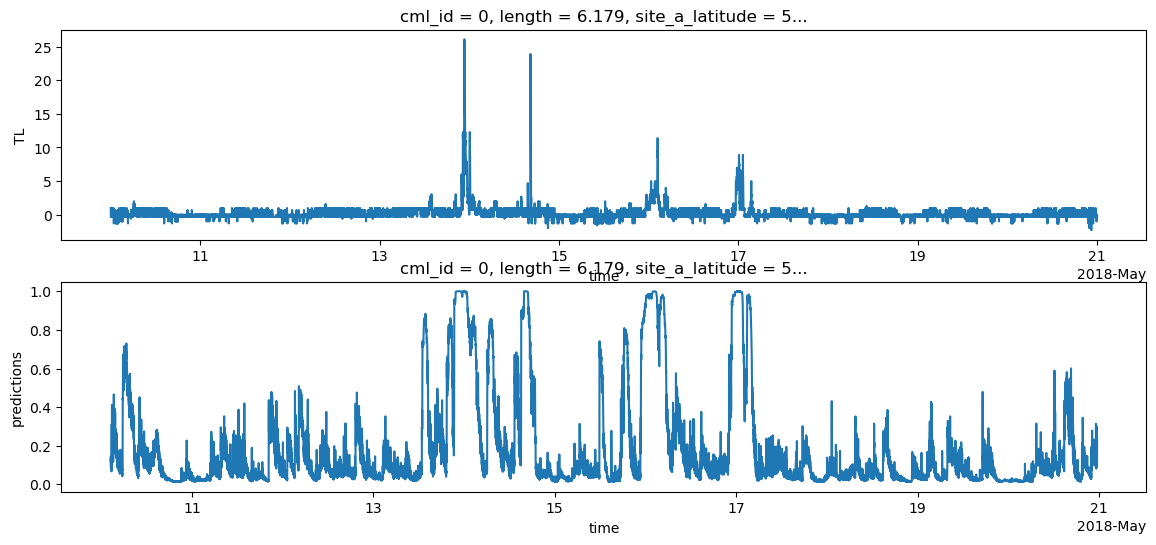

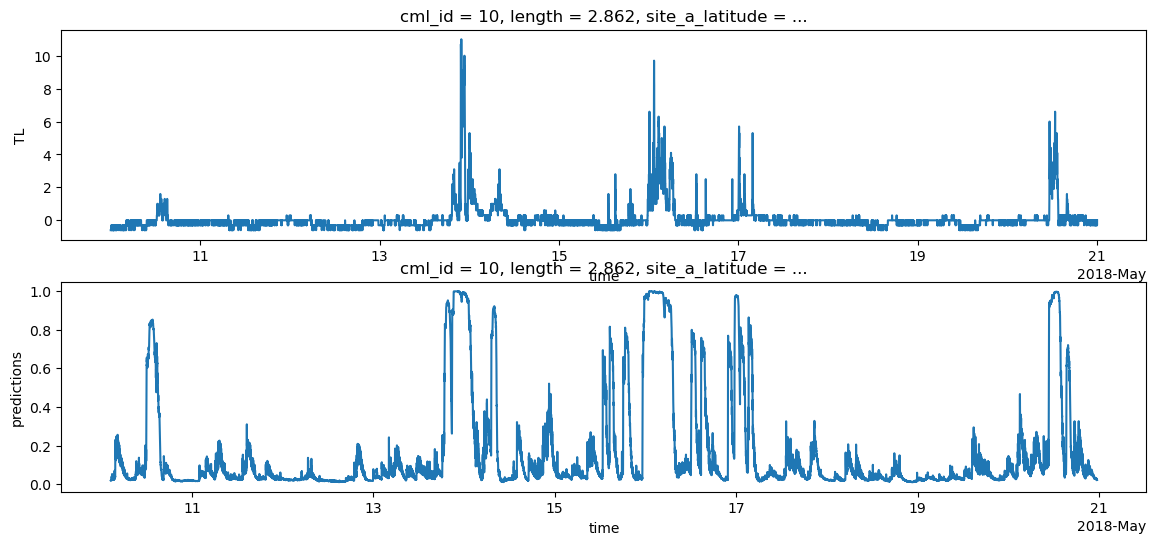

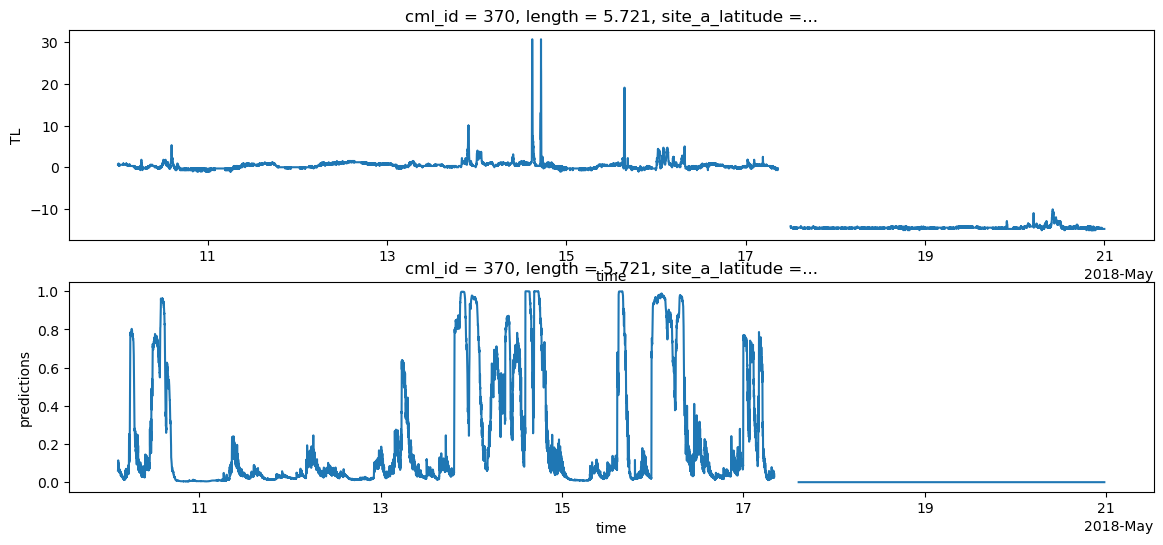

In [8]:
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(2, 1, figsize=(14, 6))
    result.TL.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    result.predictions.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    
